# convert dump to csv

In [1]:
import re

In [2]:
import pandas as pd

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def dump_to_csv(dump_filename):
    begin_regex = re.compile(r'^COPY (?P<table_name>\w+) \((?P<columns>.*?)\) FROM stdin;$')
    end_regex = re.compile('^\\\.$')
    in_table = False
    outfile = None
    with open(dump_filename, 'r') as f:
        for line in f:
            if not in_table:
                m = begin_regex.search(line)
                if m is not None:
                    target_table = m.group('table_name')
                    columns = m.group('columns').split(', ')
                    in_table = True
                    outfile = open('{}.csv'.format(target_table), 'w')
                    outfile.write('{}\n'.format('\t'.join(columns)))
                    continue
            else:
                if end_regex.match(line) is not None:
                    in_table = False
                    outfile.close()
                    continue
                else:
                    outfile.write(line)

In [5]:
%%time
tables = dump_to_csv('public_postgresql/databases/PostgreSQL.sql')

CPU times: user 4.56 s, sys: 938 ms, total: 5.5 s
Wall time: 5.71 s


# evaluate gems

In [6]:
%%time
gems = pd.read_csv('rubygems.csv', sep='\t', parse_dates=['created_at'], usecols=['created_at', 'id'],
                    index_col='created_at').rename(columns={'id': 'gems'})

CPU times: user 185 ms, sys: 26.6 ms, total: 212 ms
Wall time: 212 ms


In [7]:
# the actual magic :)
gems_cumsum = gems.groupby(gems.index.date).count().cumsum()

In [8]:
gems_cumsum.to_csv('rubygems_cumsum.csv', index_label='day')

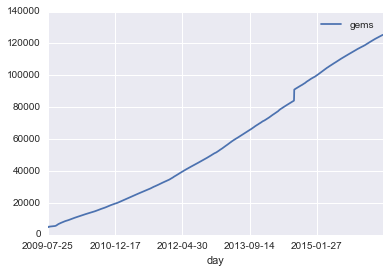

In [9]:
gems_cumsum = pd.read_csv('rubygems_cumsum.csv', index_col='day')
# plot to png
gems_cumsum.plot().get_figure().savefig('rubygems.png')

# dependencies

In [ ]:
%%time
deps = pd.read_csv('dependencies.csv', sep='\t', parse_dates=['created_at'], usecols=['created_at', 'id'],
                   index_col='created_at').rename(columns={'id': 'deps'})

In [ ]:
# calculate the cumulative sums of the count of newly added dependencies for each day
deps_cumsum = deps.groupby(deps.index.date).count().cumsum()

In [ ]:
deps_cumsum.to_csv('dependencies_cumsum.csv', index_label='day')

In [ ]:
deps_cumsum = pd.read_csv('dependencies_cumsum.csv', index_col='day')
deps_cumsum.plot().get_figure().savefig('dependencies.png')

# merge dataframes

In [136]:
deps_cumsum = pd.read_csv('dependencies_cumsum.csv', index_col='day')
gems_cumsum = pd.read_csv('rubygems_cumsum.csv', index_col='day')
cumsum = deps_cumsum.join(gems_cumsum)

In [137]:
cumsum['deps_per_gem'] = cumsum['deps']/cumsum['gems']

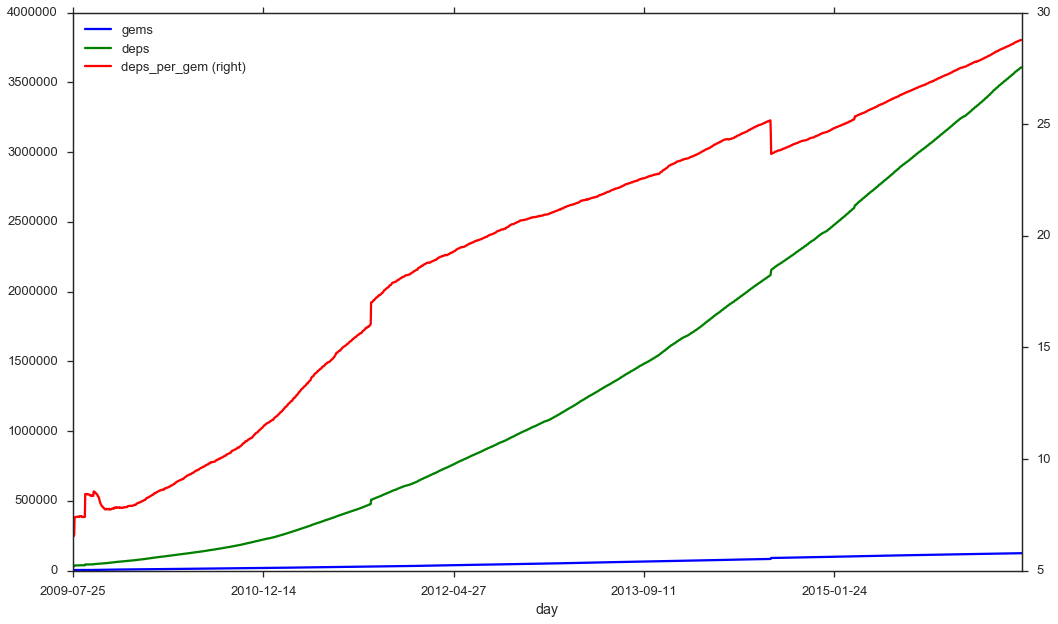

In [141]:
sns.set(style='ticks', context='talk')
plt.figure(figsize=(17, 10))
cumsum.gems.plot(legend=True, style='b-')
cumsum.deps.plot(legend=True, style='g-')
cumsum.deps_per_gem.plot(legend=True, style='r-', secondary_y=True)
fig = plot.get_figure()
fig.savefig('plot.png')
#sns.despine()
# cumsum.plot().get_figure().savefig('plot.png')